In [1]:
'''
Author:  Areg Danagoulian
date: 09.16.2024
License: see README

This is a basic notebook for 
- basic exercises in ROOT
- reading in the .dat output from grasshopper, and analyzing it using pyroot
- outputing the .dat content into a .root file
'''


import ROOT #this will take a few seconds
#NOTE: to be able to use ROOT you need to do
# > conda install pyroot

In [2]:
# Create a ROOT TCanvas
canvas = ROOT.TCanvas("canvas", "PyROOT Example", 800, 600)

In [3]:
# Create a histogram
hist = ROOT.TH1F("hist", "Example Histogram", 100, -3, 3) #100 bins, from -3 to 3

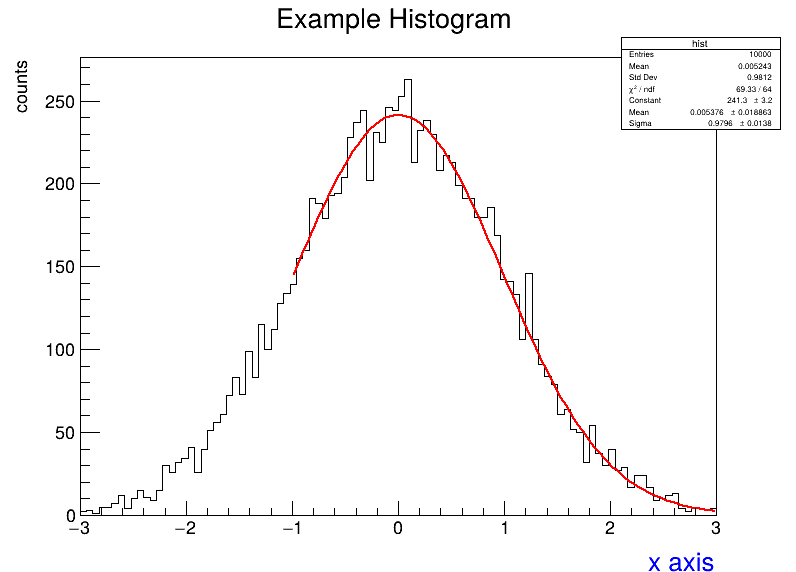

In [4]:
hist.Reset() #empty

# Fill the histogram with random data
for _ in range(10000):
    hist.Fill(ROOT.gRandom.Gaus(0, 1))

# Set histogram style
#hist.SetFillColor(ROOT.kBlue) #if you wanna set a fill color, otherwise it's transparent
hist.SetFillStyle(0) #0 is empty, anything else is filled
hist.SetLineColor(ROOT.kBlack)

# Draw the histogram on the canvas
hist.Draw()
hist.GetXaxis().SetTitle("x axis")
hist.GetXaxis().SetTitleSize(0.05)
hist.GetXaxis().SetTitleColor(ROOT.kBlue)
hist.GetYaxis().SetTitle("counts")


# Create a label
label = ROOT.TLatex()
label.SetTextSize(0.04)
label.DrawLatex(-1, 30, "Here's some LaTex: E = #hbar#omega")

# Show the canvas
canvas.Update()
canvas.Draw()

In [5]:
# Run the interactive event loop
#ROOT.gApplication.Run()

print("Hist mean and std-dev:\t",hist.GetMean(),"+-", hist.GetMeanError(), hist.GetStdDev(),"+-", hist.GetStdDevError())
print("Counts in the hist:\t",hist.Integral()) #note that this will not be 1000 -- can you say why?

Hist mean and std-dev:	 0.005243116224758071 +- 0.00982717555208467 0.9812423716569529 +- 0.006948862472789724
Counts in the hist:	 9970.0


In [6]:
fitresult=hist.Fit("gaus","","",-1,3) #now let's fit a gaussian to it. More info: https://root.cern/root/html534/TH1.html#TH1:Fit
hist.Draw()
ROOT.gStyle.SetOptFit(1)
ROOT.TPaveStats(0.0,10,0.,10,"brNDC")
canvas.Print("canvas.pdf")
f=hist.GetFunction("gaus") #get the fit function pointer from the histogram
print("Fit mean and std. dev:\t",f.GetParameter(1),f.GetParameter(2))
print("Fit Chi2 / NDF:\t",f.GetChisquare()," / ",f.GetNDF())
#hist.Draw()  #it appears that when you have any kind of print statement it won't draw in the same cell
#canvas.Draw()

Fit mean and std. dev:	 0.0053755500215024515 0.9796178999392335
Fit Chi2 / NDF:	 69.33089280404955  /  64
****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      69.3309
NDf                       =           64
Edm                       =  8.71688e-06
NCalls                    =           70
Constant                  =      241.265   +/-   3.16081     
Mean                      =   0.00537555   +/-   0.0188633   
Sigma                     =     0.979618   +/-   0.0137538    	 (limited)


Info in <TCanvas::Print>: pdf file canvas.pdf has been created


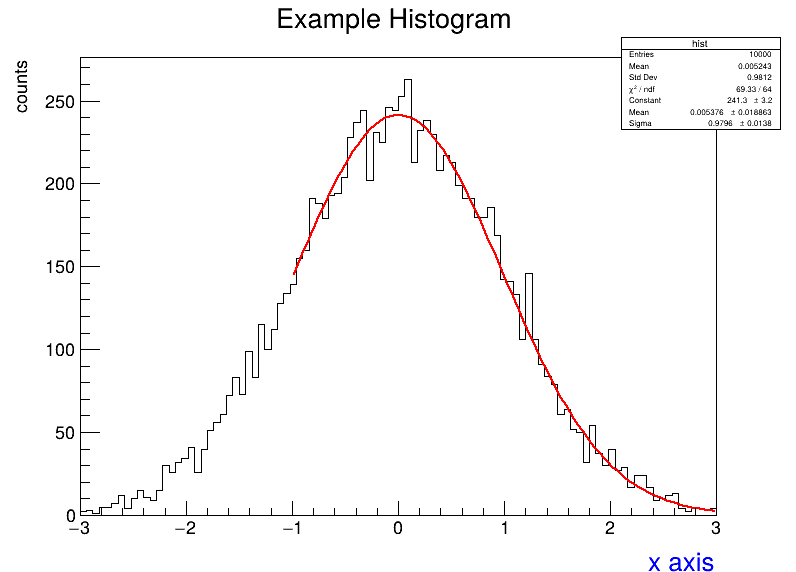

In [7]:
#after a fit, need a separate cell with prints
hist.Draw()
canvas.Draw()

# Reading in data files and analyzing the contents

Here we first need to create a TTree tree, which we will then fill with the content of the text file.  It helps however to also create a .root binary file, which then root can serialize your data to -- making for an easier opening next time.

In [8]:
file = ROOT.TFile("tree.root", "recreate") #open a new root file on disk.  This is not necessary -- only if you want to save everything in a .root file

# Create a TTree object in memory.
tree = ROOT.TTree("tree", "tree")

In [9]:
#below the second field is the branch description.  /D means that E_beam is a double.  /I means integer. /C means that CreatorProcess is a character array
tree.ReadFile("test.dat","E_beam/D:E/D:EventID/I:ParticleName/C:CreatorProcess/C:Time/D:Detector/I")
print("Read ",tree.GetEntries()," entries.")
tree.Write() #write the contents to disk

Read  406  entries.


930

Warning in <TTree::ReadStream>: Couldn't read formatted data in "E_beam(MeV)" for branch E_beam on line 1; ignoring line
Warning in <TTree::ReadStream>: Read too few columns (1 < 7) in line 1; ignoring line


In [10]:
tree.Draw("ParticleName:CreatorProcess","","colz") #the third field specifies the style.  Col means false color
hist_2d=tree.GetHistogram() #.Draw automatically creates a histogram.  You need to get access to it though.

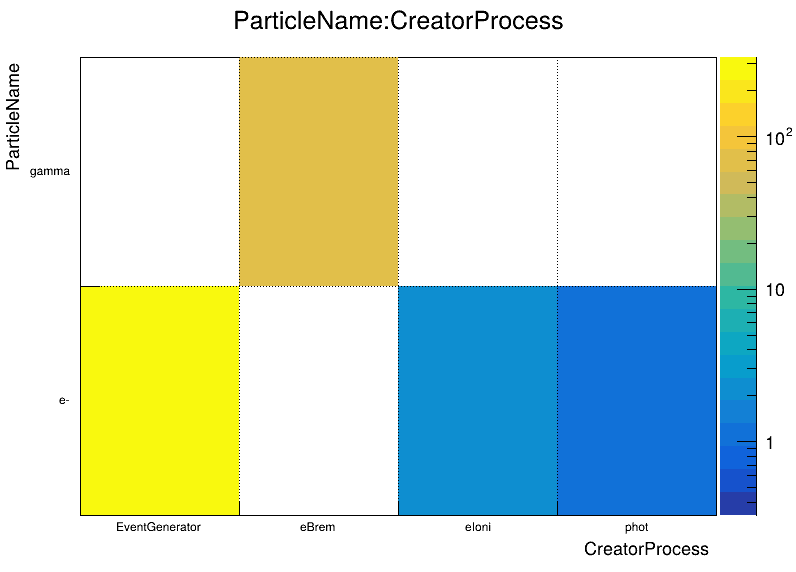

In [11]:
hist_2d.Draw("colz") #now that you have the histogram you can draw it.
canvas.SetLogy(0)
canvas.SetLogz(1) #when the events are highly non-uniformly distributed having a log-Z axis can be useful
canvas.SetGrid(1)
canvas.Draw()

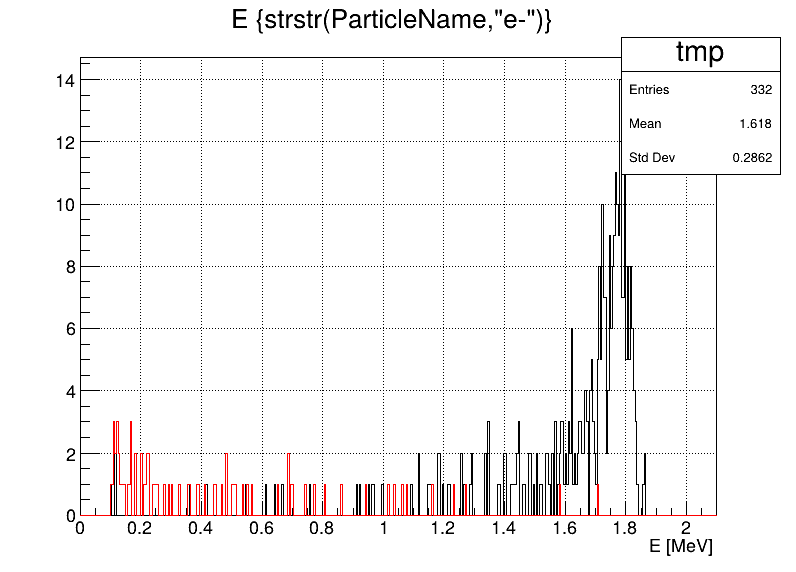

In [12]:
tree.Draw("E>>tmp(420,0,2.1)","strstr(ParticleName,\"e-\")","") #histogram energy but only for electrons! On the fly create tmp with 200 bins from 0 to 2 MeV
#strstr returns a True when the two entries are identical. Note that the string comparison needs to have \ before " 
hist_e=tree.GetHistogram()
hist_e.SetLineColor(ROOT.kBlack)
hist_e.GetXaxis().SetTitle("E [MeV]")
tree.Draw("E>>tmp2(420,0,1.1)","strstr(ParticleName,\"gamma\")","same") #histogram energy but only for gammas 
#strstr returns a True when the two entries are identical. Note that the string comparison needs to have \ before " 
hist_gamma=tree.GetHistogram()
hist_gamma.Draw()
hist_gamma.SetLineColor(ROOT.kRed)
hist_gamma.GetXaxis().SetTitle("E [MeV]")
hist_e.Draw("")
hist_gamma.Draw("same")
canvas.SetLogy(0)
canvas.Draw()

****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      31.2529
NDf                       =           27
Edm                       =  4.31449e-07
NCalls                    =           69
Constant                  =      8.68545   +/-   0.933444    
Mean                      =      1.77457   +/-   0.00384685  
Sigma                     =    0.0400181   +/-   0.00408843   	 (limited)


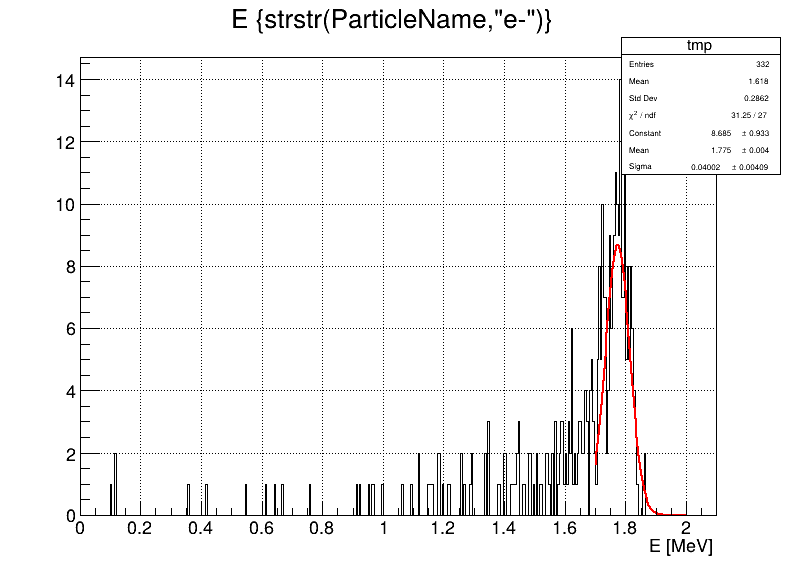

In [16]:
hist_e.Draw("")
fitresult=hist_e.Fit("gaus","","",1.7,2)
canvas.Draw()

In [ ]:
file.Close() #close the root file.  However if you close it you lose access to everything.